# How to regrid sea ice concentration

This notebook demonstrates how to regrid daily sea ice concentration data from Near-Real-Time DMSP SSMIS Daily Polar Gridded Sea Ice Concentrations, Version 2, from the data's native grid and projection to a 25 km grid in the NSIDC EASE-2 projection.  The dataset id is NSIDC-0081 and the DOI is 10.5067/YTTHO2FJQ97K.  Further information about the data can be found on the dataset landing page https://nsidc.org/data/nsidc-0081/versions/2.

The data are in a 25 km grid on NSIDC's North Polar Stereographic projection.  The data are stored in NetCDF files.

## What you will learn
- How to open a CF-Compliant NetCDF file using `rioxarray` and `xarray`.
- How to define a destination grid for your reprojected data.
- How to use `rio.reproject` to reproject the data.
- How to write the reprojected data to an output file.

In [1]:
from pathlib import Path

import rioxarray
import xarray as xr

from affine import Affine

EXAMPLE_DATA = Path('../example_data/NSIDC0081_SEAICE_PS_N25km_20230627_v2.0.nc')

## Open the NetCDF file

`xarray` is a package for working with multi-dimensional gridded data.  The data structures `xarray.DataArray` and `xarray.Dataset` are based on the NetCDF data model, making it the ideal package to work with data stored as NetCDF.  `rioxarray` extends `xarray` making it "coordinate reference system aware".  A _coordinate reference system_ (CRS) is what makes Geospatial data, geospatial.  It allows data to be _georeferenced_ to the Earth (or other celestial body).  `rioxarray` allows `xarray.DataArray` and `xarray.Dataset` objects to be cropped, resampled to different grids, and reprojected.

A NetCDF file is opened using `open_dataset`.  Setting `decode_coords='all'`, loads the `grid_mapping` variable to be loaded as a coordinate that is used by `rioxarray` for resampling and reprojection.

The `mask_and_scale` keyword is set to `False`.  The data are scaled so they can be stored as unsigned-byte data to save space.  Values range from 0 to 255.  The sea ice concentration grids (`F16_ICECON`, `F17_ICECON`, and `F18_ICECON`) have flag values embedded in the data.  Valid data are coded 0 to 250.  Cells with values 251, 252, 253 and 254 represent the pole hole, unused cells, coast and land cells.  Cells with a value 255 are defined as `_FillValue`.  `xarray` automatically masks cells with values equal to `_FillValue` and unpacks cells with other values using the `scale_factor` and `add_offset`.  This means that `flag_values` are also unpacked.  This is not a CF-Compliant approach.  _Ideally, non-data values, ie.e cells that do not have a sea ice concentration, are set to `_FillValue`, and flag values are contained in a separate mask variable._

In [15]:
ds = xr.open_dataset(EXAMPLE_DATA, decode_coords='all', mask_and_scale=False)

In [16]:
ds

<xarray.Dataset>
Dimensions:     (x: 304, y: 448, time: 1)
Coordinates:
    crs         |S1 ...
  * x           (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y           (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
  * time        (time) datetime64[ns] 2023-06-27
Data variables:
    F16_ICECON  (time, y, x) uint8 ...
    F17_ICECON  (time, y, x) uint8 ...
    F18_ICECON  (time, y, x) uint8 ...
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...

The minimum and maximum values are 0 and 255.

In [17]:
ds.F17_ICECON.min().values, ds.F17_ICECON.max().values

(array(0, dtype=uint8), array(255, dtype=uint8))

The data can be plotted to show the full range and distribution of values.

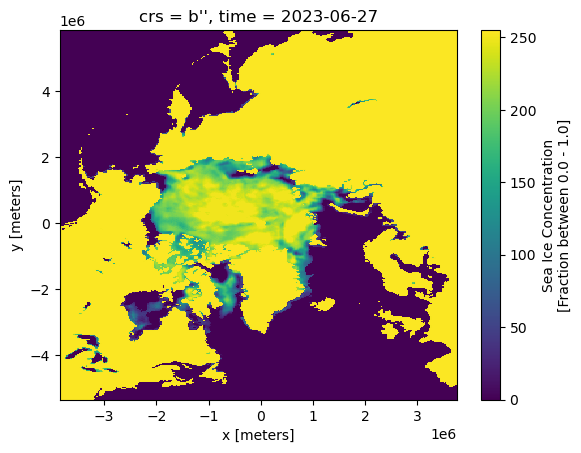

In [18]:
ds.F16_ICECON[0,:,:].plot()

Valid data values can be identified and plotted using `where`.  Here, values <= 250 are retained as valid values.  Values greater than 250 are set to NaN.  This is how `xarray` interprets missing values.

_I need to check on how `xarray` unpacks values outside `valid_range` if they are not `_FillValue`._

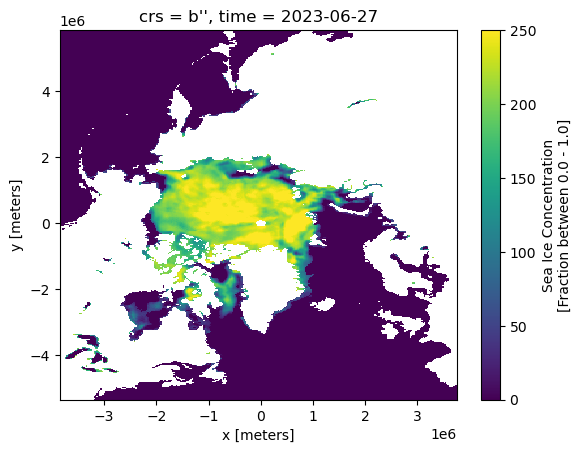

In [20]:
ds.F16_ICECON[0,:,:].where(ds.F16_ICECON <= 250).plot()

In [12]:
ds.rio.crs

CRS.from_wkt('PROJCS["NSIDC Sea Ice Polar Stereographic North",GEOGCS["Unspecified datum based upon the Hughes 1980 ellipsoid",DATUM["Not_specified_based_on_Hughes_1980_ellipsoid",SPHEROID["Hughes 1980",6378273,298.279411123061,AUTHORITY["EPSG","7058"]],AUTHORITY["EPSG","6054"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4054"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","3411"]]')

In [13]:
ds.rio.transform()

Affine(25000.0, 0.0, -3850000.0,
       0.0, -25000.0, 5850000.0)

## Reproject to a 25 km EASE v2.0 grid

### Define destination CRS

As discussed above, the CRS for a grid consists of a map projection and a function that relates grid columns and rows to map coordinates.  For EASE grids, this information is found in NSIDC's [A Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids).  There are many, many EASE Grids.  The definitions for standard 25 km grids are given in the table of [25 km resolution EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids#anchor-9).  Row 5 of this table gives the definitions for a 25 km resolution grid on EASE version 2.0.

To reproject the Polar Stereographic projection to this grid, we have to pass the projection parameters for EASE 2.0 North, the shape of the grid (height in rows and width in columns), the grid cell height and width in the units of the projected coordinates, the coordinates of the upper-left corner of the grid.  For EASE 2.0 North, we can use the EPSG code (EPSG:6931) for the projection definition.  The rest of the information is in the columns. 

In [22]:
destination_crs = 'EPSG:6931'
ncols = 720
nrows = 720
cell_width = 25000.0
cell_height = -25000.0
grid_upper_left_x = -9000000.0
grid_upper_left_y = 9000000.0

To match the 25 km resolution EASE 2.0 grid defined in [A Guide to EASE Grids](https://nsidc.org/data/user-resources/help-center/guide-ease-grids), the shape of the grid and an _affine transformation matrix_ must be defined.  If the `resolution` option is used the reprojection algorithm estimates a grid with the defined resolution but with an extent and bounds based on the input grid. 

An _affine transformation matrix_ defines how row and column indices of a raster or grid are related to the projected coordinate system.  A good description of geospatial affine transformation matrices can be found [here](https://www.perrygeo.com/python-affine-transforms.html).

The affine matrix is a 6 element matrix:

$$
\begin{vmatrix}
a & b & c\\
d & e & f
\end{vmatrix}
$$

where

> $a$ width of a grid cell<br>
> $b$ row rotation (normally zero)<br>
> $c$ x coordinate of the upper-left corner of the grid<br>
> $d$ column rotation (normally zero)<br>
> $e$ height of a grid cell (negative if the grid-origin is the upper-left corner)<br>
> $f$ y coordinate of the upper-left corner of the grid<br>

The `Affine` class of the python `affine` package is used to define the transform.

In [23]:
gt = (cell_width, 0.0, grid_upper_left_x, 0.0, cell_height, grid_upper_left_y)
transform = Affine(*gt)
transform

Affine(25000.0, 0.0, -9000000.0,
       0.0, -25000.0, 9000000.0)

The shape of the grid is defined as a `tuple` containing the height of the grid in number of rows, and the width of the grid as number of columns.

```
shape=(nrows,ncols)
```

Because the data have flag values embedded, we do not want to interpolate the data to the new grid.  Instead we want to use a nearest-neighbor regridding algorithm.  This is the default behaviour for `rio.xarray`.

In [24]:
ds_ease2 = ds.rio.reproject(destination_crs, shape=(nrows, ncols), transform=transform)

In [25]:
ds_ease2

<xarray.Dataset>
Dimensions:     (x: 720, y: 720, time: 1)
Coordinates:
  * x           (x) float64 -8.988e+06 -8.962e+06 ... 8.962e+06 8.988e+06
  * y           (y) float64 8.988e+06 8.962e+06 ... -8.962e+06 -8.988e+06
  * time        (time) datetime64[ns] 2023-06-27
    crs         int64 0
Data variables:
    F16_ICECON  (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    F17_ICECON  (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
    F18_ICECON  (time, y, x) uint8 255 255 255 255 255 ... 255 255 255 255 255
Attributes: (12/49)
    title:                     Near-Real-Time DMSP SSMIS Daily Polar Gridded ...
    summary:                   This data set provides a Near-Real-Time (NRT) ...
    id:                        10.5067/YTTHO2FJQ97K
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    metadata_link:             https://doi.org/10.5067/YTTHO2FJQ97K
    ...                        ...
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           v2.0
    source:                    NOAA Comprehensive Large Array-data Stewardshi...
    instrument:                SSMIS > Special Sensor Microwave Imager/Sounde...
    platform:                  DMSP 5D-3/F16 > Defense Meteorological Satelli...

Ploting the reprojected data, it is seen that cells in the new grid are set to 255, the `_FillValue`.

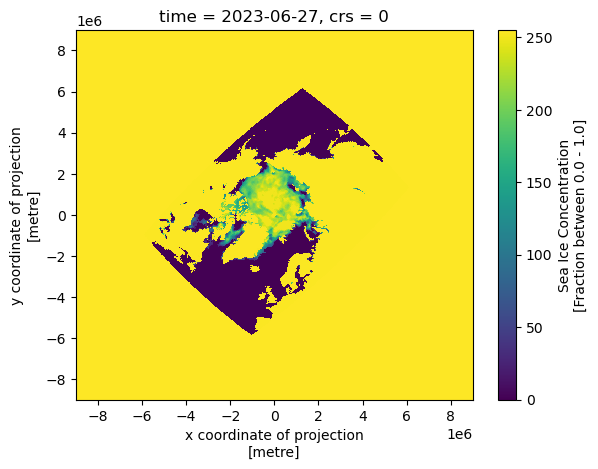

In [27]:
ds_ease2.F16_ICECON[0,:,:].plot()

To unpack the data and for further processing it is useful to set all values outside of the valid range to missing.  In `xarray` and this is NaN.  We can use `where` to do this.

In [28]:
mask = ds_ease2.F16_ICECON <= 250
ds_ease2 = ds_ease2.where(mask)

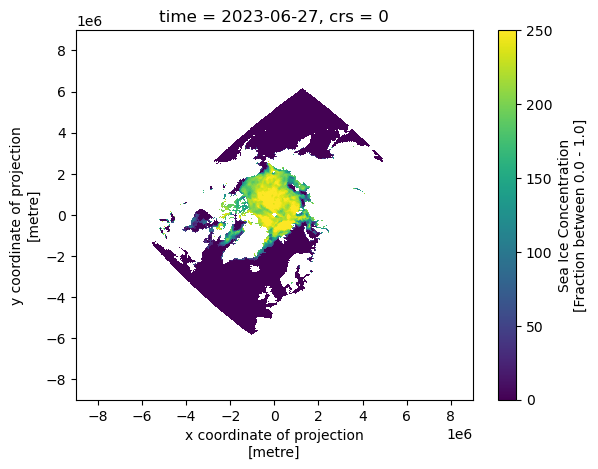

In [29]:
ds_ease2.F16_ICECON[0,:,:].plot()

We can now unpack the data so that sea ice concentration is between 0 and 1.0.

In [30]:
ds_ease2 = xr.decode_cf(ds_ease2)

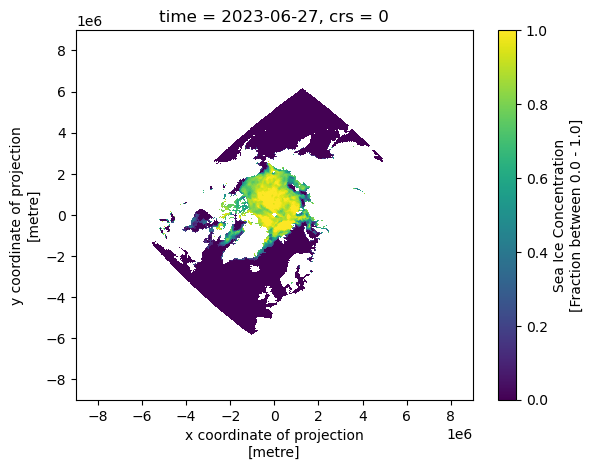

In [34]:
ds_ease2.F16_ICECON[0,:,:].plot()